In [1]:
#%% [code]
# Suppress warnings (if desired)
import warnings
warnings.filterwarnings("ignore")

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage
import SimpleITK as sitk

from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
sns.set(style="whitegrid")

#%% [code]
# Constants and file paths
INPUT_FOLDER = '/kaggle/input/luna16/subset0/subset0'
ANNOTATIONS_FILE = '/kaggle/input/luna16/annotations.csv'

# List all .mhd files in the input folder (each representing a patient CT scan)
ct_scan_files = sorted([f for f in os.listdir(INPUT_FOLDER) if f.endswith('.mhd')])
print(f"Found {len(ct_scan_files)} CT scan files.")

Found 89 CT scan files.


In [3]:
def load_ct_scan(mhd_path):
    """
    Load a CT scan from a .mhd file using SimpleITK.
    Returns:
      - scan: 3D NumPy array (slices, rows, cols)
      - origin: (x,y,z) world coordinates of the image origin
      - spacing: (x,y,z) voxel spacing, where typically x=column spacing, y=row spacing, and z=slice thickness
    """
    itk_img = sitk.ReadImage(mhd_path)
    scan = sitk.GetArrayFromImage(itk_img)
    origin = np.array(itk_img.GetOrigin())
    spacing = np.array(itk_img.GetSpacing())
    return scan, origin, spacing


In [4]:
# Test by loading the first scan
sample_path = os.path.join(INPUT_FOLDER, ct_scan_files[0])
sample_scan, sample_origin, sample_spacing = load_ct_scan(sample_path)
print("Sample scan shape:", sample_scan.shape)
print("Origin (mm):", sample_origin)
print("Spacing (mm):", sample_spacing)

Sample scan shape: (121, 512, 512)
Origin (mm): [-198.100006 -195.       -335.209991]
Spacing (mm): [0.76171899 0.76171899 2.5       ]


In [5]:
# --------------------------
# Section 2: Transforming to Hounsfield Units (HU)
# --------------------------
def convert_to_hu(scan, intercept=-1024):
    """
    Convert a raw CT scan to Hounsfield Units (HU).
    Many LUNA16 scans set pixels outside the scan to -2000.
    This function resets those values to 0 and applies the intercept.
    """
    hu_scan = scan.astype(np.int16)
    hu_scan[hu_scan == -2000] = 0
    hu_scan += intercept
    return hu_scan


In [6]:
# Apply conversion on sample scan
sample_hu = convert_to_hu(sample_scan)
print("HU scan statistics:", np.min(sample_hu), np.max(sample_hu))

HU scan statistics: -4048 1079


In [7]:
#%% [code]
# --------------------------
# Section 3: Voxel Properties, Slice Area, and Volume (EDA)
# --------------------------
def compute_scan_properties(scan, spacing):
    """
    Compute basic physical properties of a CT scan:
      - Slice area in cm² (using row & column spacing)
      - Slice volume in cm³ (using slice thickness)
    """
    # Get image dimensions
    num_slices, rows, cols = scan.shape
    # Spacing: [col_spacing, row_spacing, slice_thickness] (in mm)
    col_spacing, row_spacing, slice_thickness = spacing
    area_mm2 = (row_spacing * rows) * (col_spacing * cols)
    area_cm2 = area_mm2 / 100.0
    volume_cm3 = area_cm2 * (slice_thickness / 10.0)  # converting mm to cm for thickness
    return area_cm2, volume_cm3

In [8]:
area_cm2, volume_cm3 = compute_scan_properties(sample_scan, sample_spacing)
print(f"Sample slice area: {area_cm2:.2f} cm², Slice volume: {volume_cm3:.2f} cm³")

Sample slice area: 1521.00 cm², Slice volume: 380.25 cm³


In [9]:
# (Optional) Loop over all scans to compile a DataFrame of properties:
properties = []
for fname in ct_scan_files:
    path = os.path.join(INPUT_FOLDER, fname)
    scan, orig, sp = load_ct_scan(path)
    area, vol = compute_scan_properties(scan, sp)
    properties.append({
        'seriesuid': os.path.splitext(fname)[0],
        'rows': scan.shape[1],
        'columns': scan.shape[2],
        'slice_thickness': sp[2],
        'area_cm2': area,
        'slice_volume_cm3': vol,
        'col_spacing': sp[0],
        'row_spacing': sp[1]
    })
df_properties = pd.DataFrame(properties)
print(df_properties.head())

                                           seriesuid  rows  columns  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...   512      512   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...   512      512   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   512      512   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...   512      512   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896...   512      512   

   slice_thickness     area_cm2  slice_volume_cm3  col_spacing  row_spacing  
0            2.500  1521.000952        380.250238     0.761719     0.761719  
1            2.500  1444.001855        361.000464     0.742188     0.742188  
2            1.250   789.609657         98.701207     0.548828     0.548828  
3            0.625  1444.001855         90.250116     0.742188     0.742188  
4            2.500   992.248846        248.062212     0.615234     0.615234  


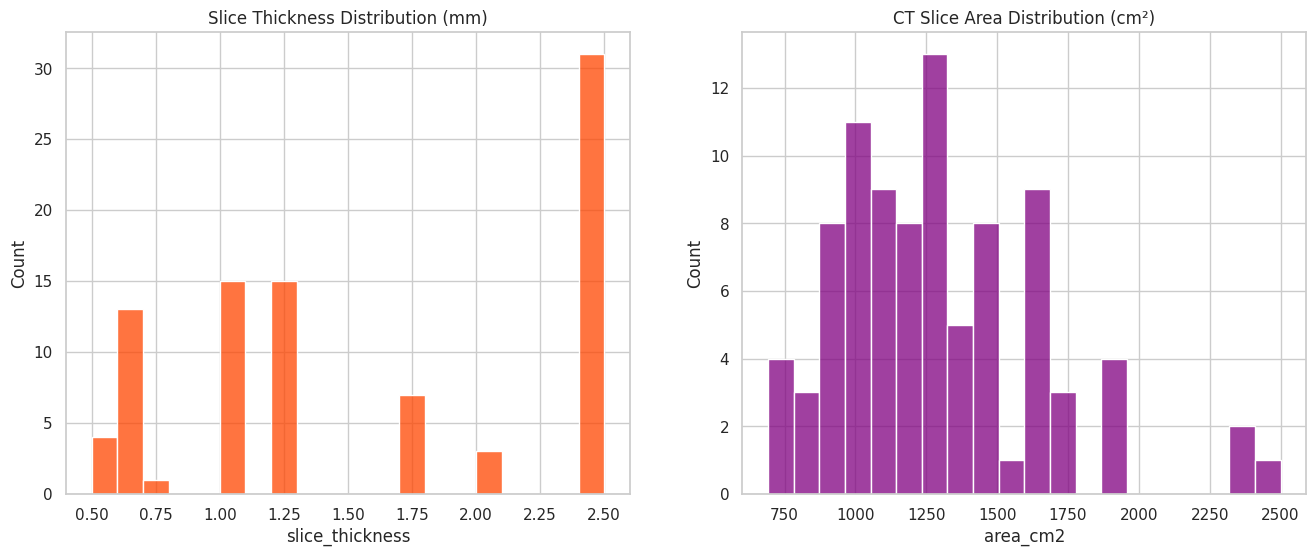

In [10]:
#%% [code]
# Visualize distributions of properties (example: slice thickness and area)
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.histplot(df_properties['slice_thickness'], bins=20, color="orangered", ax=ax[0])
ax[0].set_title("Slice Thickness Distribution (mm)")
sns.histplot(df_properties['area_cm2'], bins=20, color="purple", ax=ax[1])
ax[1].set_title("CT Slice Area Distribution (cm²)")
plt.show()

In [11]:
#%% [code]
# --------------------------
# Section 4: 3D Reconstruction of CT Scan
# --------------------------
def plot_3d_reconstruction(image, threshold=-300):
    """
    Create a 3D surface reconstruction of a CT scan using marching cubes.
    image: 3D NumPy array (HU values)
    threshold: intensity threshold for surface extraction
    """
    # Reorient image: transpose to (x, y, z)
    img_transposed = image.transpose(2, 1, 0)
    verts, faces, normals, values = measure.marching_cubes(img_transposed, level=threshold)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(verts[faces], alpha=0.7)
    mesh.set_facecolor([0.45, 0.45, 0.75])
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, img_transposed.shape[0])
    ax.set_ylim(0, img_transposed.shape[1])
    ax.set_zlim(0, img_transposed.shape[2])
    plt.title("3D CT Scan Reconstruction")
    plt.show()

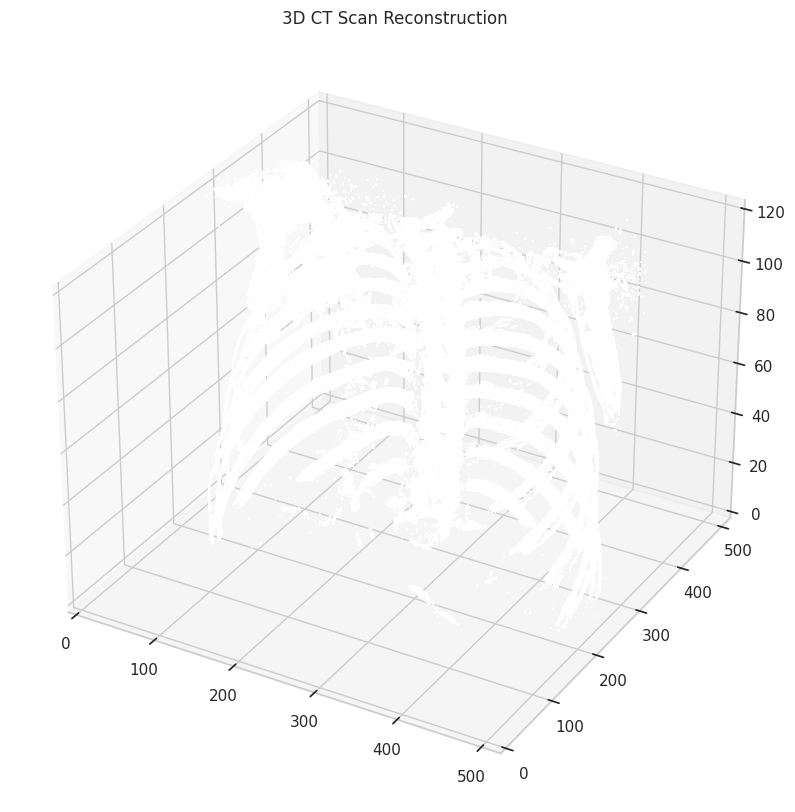

In [12]:
# Visualize sample 3D reconstruction
plot_3d_reconstruction(sample_hu, threshold=-300)


In [13]:
#%% [code]
# --------------------------
# Section 6: 3D Visualization of Pulmonary Nodules with Annotations
# --------------------------
# Load annotation data (assumes annotations CSV with columns like seriesuid, coordX, coordY, coordZ)
df_annotations = pd.read_csv(ANNOTATIONS_FILE)
print("Annotations sample:")
print(df_annotations.head())

def get_series_uid_from_path(mhd_path):
    """
    Extract the unique series UID from the .mhd filename.
    """
    return os.path.splitext(os.path.basename(mhd_path))[0]

# Helper function: convert world (physical) coordinates (mm) to voxel coordinates.
def world_to_voxel(world_coords, origin, spacing):
    """
    Convert world coordinates (mm) to voxel coordinates.
    
    Parameters:
      world_coords : np.array([x, y, z])
      origin       : np.array([x, y, z]) in mm
      spacing      : np.array([x, y, z]) in mm
      
    Returns:
      Voxel coordinates as an integer np.array.
    """
    return np.round((world_coords - origin) / spacing).astype(int)

# Function to visualize only the pulmonary nodules.
def plot_nodules_only_3d(annotations, origin, spacing, seriesuid):
    """
    Create a 3D scatter plot showing only the pulmonary nodules (red markers) 
    for a given CT scan series.
    
    Parameters:
      annotations : DataFrame containing nodule annotations (with columns 'seriesuid', 'coordX', 'coordY', 'coordZ')
      origin      : CT scan origin in mm (np.array of shape (3,))
      spacing     : Voxel spacing in mm (np.array of shape (3,))
      seriesuid   : String identifier for the CT scan (should match the 'seriesuid' in annotations)
    """
    # Filter annotations for this series UID.
    nodules = annotations[annotations['seriesuid'] == seriesuid]
    
    if nodules.empty:
        print("No nodule annotations found for series:", seriesuid)
        return
    
    # Convert each nodule's world coordinates to voxel coordinates.
    voxel_coords = []
    for idx, row in nodules.iterrows():
        world_coords = np.array([row['coordX'], row['coordY'], row['coordZ']])
        v_coords = world_to_voxel(world_coords, origin, spacing)
        voxel_coords.append(v_coords)
    
    voxel_coords = np.array(voxel_coords)  # shape: (num_nodules, 3)
    
    # Determine axis limits from the nodules (with some padding).
    pad = 10
    x_min, x_max = voxel_coords[:,0].min()-pad, voxel_coords[:,0].max()+pad
    y_min, y_max = voxel_coords[:,1].min()-pad, voxel_coords[:,1].max()+pad
    z_min, z_max = voxel_coords[:,2].min()-pad, voxel_coords[:,2].max()+pad
    
    # Create a 3D scatter plot.
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(voxel_coords[:,0], voxel_coords[:,1], voxel_coords[:,2],
               color='red', s=200, label='Pulmonary Nodule')
    
    ax.set_xlabel("X (voxel)")
    ax.set_ylabel("Y (voxel)")
    ax.set_zlabel("Z (voxel)")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    
    ax.set_title("3D Visualization of Pulmonary Nodules (Only)")
    ax.legend()
    plt.show()

Annotations sample:
                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150  


In [14]:
INPUT_FOLDER = '/kaggle/input/luna16/subset0/subset0'
# Select one sample mhd file (adjust as needed)
sample_path = os.path.join(INPUT_FOLDER, '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd')
itk_img = sitk.ReadImage(sample_path)
origin = np.array(itk_img.GetOrigin())     # e.g. [x, y, z] in mm
spacing = np.array(itk_img.GetSpacing())     # e.g. [col_spacing, row_spacing, slice_thickness] in mm

# Extract the series UID from the filename (without extension)
seriesuid = os.path.splitext(os.path.basename(sample_path))[0]



In [15]:

# --- Functions to load and process the scan ---

def load_scan(mhd_path):
    """
    Load a CT scan from a .mhd file (and corresponding .raw file) using SimpleITK.
    Returns the scan as a NumPy array, along with its origin and spacing.
    """
    itk_img = sitk.ReadImage(mhd_path)
    scan_array = sitk.GetArrayFromImage(itk_img)  # shape: [num_slices, height, width]
    origin = np.array(itk_img.GetOrigin())         # (x, y, z)
    spacing = np.array(itk_img.GetSpacing())         # (x, y, z)
    return scan_array, origin, spacing

def get_pixels_hu(scan_array, intercept=-1024):
    """
    Convert the scan array (raw pixel values) to Hounsfield Units (HU).
    """
    image = scan_array.astype(np.int16)
    # For LUNA16, values outside the scan are usually set to -2000.
    image[image == -2000] = 0
    image += intercept
    return image

def set_outside_scanner_to_air(raw_pixelarrays):
    """
    In some datasets (e.g. OSIC), outside-scanner regions have a raw value of -2000.
    Here we threshold these regions (using -1000 as a cutoff) to set them to 0 (air).
    """
    raw_pixelarrays[raw_pixelarrays <= -1000] = 0
    return raw_pixelarrays

def transform_to_hu(scan_array):
    """
    Transform a CT scan (3D NumPy array) into Hounsfield Units (HU).
    This mimics the behavior of iterating over slices and applying a fixed transformation.
    For LUNA16, we assume a constant slope=1 and intercept=-1024.
    """
    images = scan_array.astype(np.int16)
    images = set_outside_scanner_to_air(images)
    slope = 1
    intercept = -1024
    images = images * slope
    images = images.astype(np.int16)
    images += np.int16(intercept)
    return images

In [16]:
# --- Load one CT scan from LUNA16 ---
# Adjust the filename if needed
mhd_file = os.path.join('/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd')
scan_array, origin, spacing = load_scan(mhd_file)

# Get raw pixel values and transform them to HU.
raw_pixels = scan_array.astype(np.int16)
hu_pixels = get_pixels_hu(scan_array)
hu_scans = transform_to_hu(scan_array)

<bound method Axes.set_title of <Axes: ylabel='Density'>>

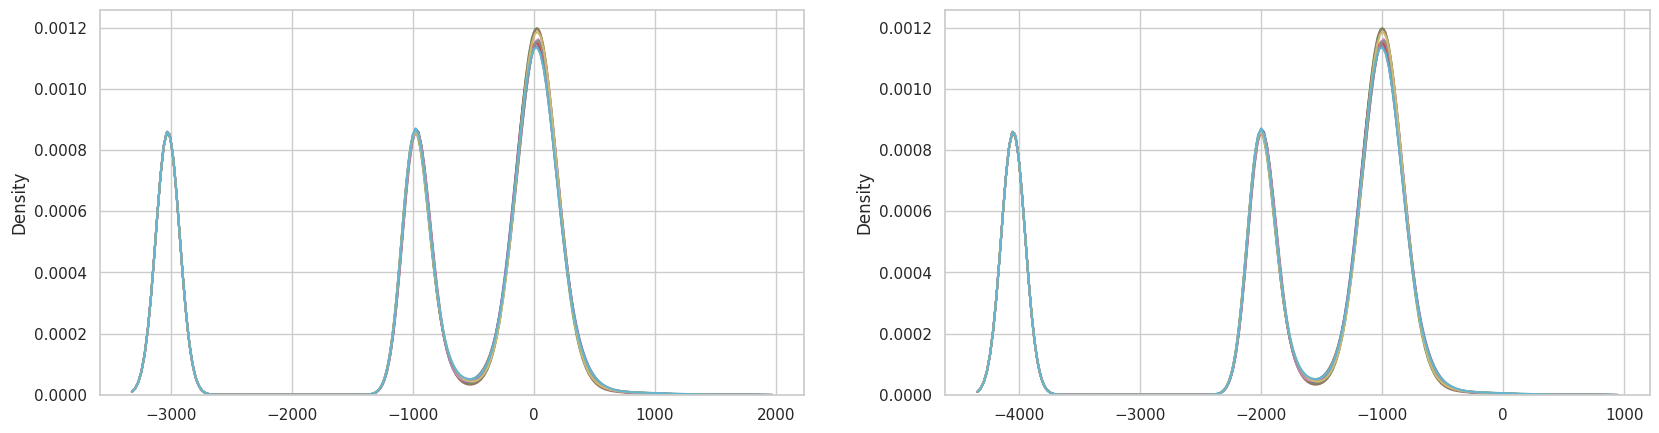

In [17]:

# --- Plot distributions for the first 10 slices using sns.kdeplot ---
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for n in range(10):
    slice_raw = raw_pixels[n].flatten()
    slice_hu = hu_pixels[n].flatten()
    sns.kdeplot(slice_raw, ax=ax[0], label=f"Slice {n}")
    sns.kdeplot(slice_hu, ax=ax[1], label=f"Slice {n}")
ax[0].set_title

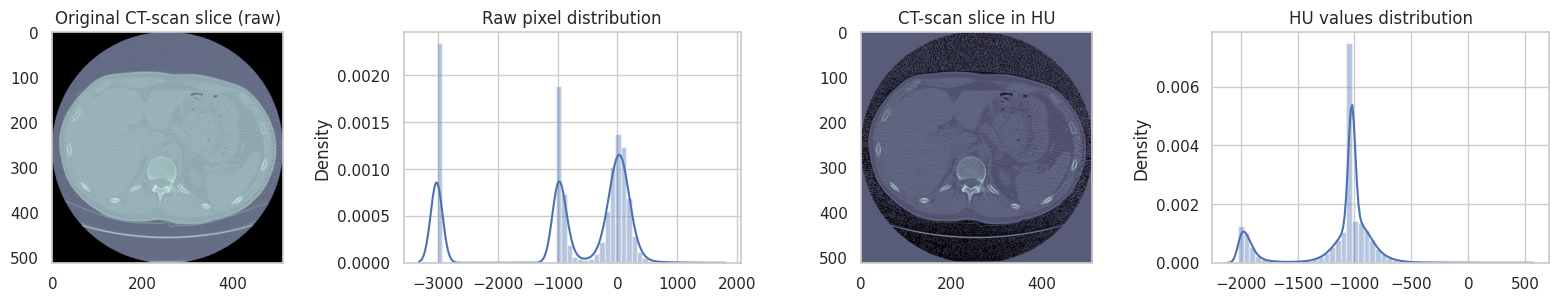

In [18]:

# --- Plot one slice and its distribution ---
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax[0].set_title("Original CT-scan slice (raw)")
ax[0].imshow(raw_pixels[0], cmap="bone")
ax[1].set_title("Raw pixel distribution")
sns.distplot(raw_pixels[0].flatten(), ax=ax[1])
ax[2].set_title("CT-scan slice in HU")
ax[2].imshow(hu_scans[0], cmap="bone")
ax[3].set_title("HU values distribution")
sns.distplot(hu_scans[0].flatten(), ax=ax[3])
for m in [0, 2]:
    ax[m].grid(False)
plt.show()